# Predict socket

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

## Configuration

In [2]:
from samples.sockets import socket

config = socket.SocketConfig()
SOCKET_DIR = os.path.join(ROOT_DIR, "dataset")

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [22]:
# class_names = ["AOP_BTV1",
#         "AOP_DIO_01",
#         "AOP_EVK80",
#         "AOP_TRAS1000",
#         "AOP_TRAS1000_no_key",
#         "AOP_X10DER_KT_01",
#         "SPLITTER_MCP_03",
#         "SPLITTER_POA_01IEC",
#         "SPLITTER_POA_01_met_kapje",
#         "SPLITTER_POA_01_zonder_kapje",
#         "SPLITTER_POA_3_met_kapje",
#         "SPLITTER_POA_3_zonder_kapje",
#         "SPLITTER_SQ601_met_kapje",
#         "SPLITTER_UMU_met_kapje",
#         "WCD_tweegats"]

class_names = ['socket','socket','socket'] # need to fix this because with manually annotating the images I only used one class but should add classes above.. just for testing purposes

## Test on validation data 

In [4]:
dataset_val = socket.SocketDataset()
dataset_val.load_socket(SOCKET_DIR, "val")
dataset_val.prepare()

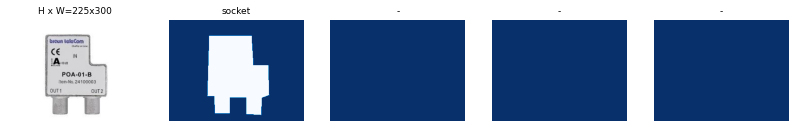

In [5]:
image_ids = np.random.choice(dataset_val.image_ids, 1)
for image_id in image_ids:
    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_val.class_names)

In [6]:
model = modellib.MaskRCNN(mode="inference", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [7]:
model_path = model.find_last()
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Loading weights from  /Users/wolfsinem/maskrcnn/logs/socket20210331T1616/mask_rcnn_socket_0001.h5
Re-starting from epoch 1


In [8]:
image_id = random.choice(dataset_val.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, config, image_id, use_mini_mask=False)
info = dataset_val.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset_val.image_reference(image_id)))



image ID: socket.SPLITTER-UMU2.png (2) /Users/wolfsinem/maskrcnn/dataset/val/SPLITTER-UMU2.png


In [9]:
# Run object detection
results = model.detect([image], verbose=1)

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  129.00000  max:  924.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


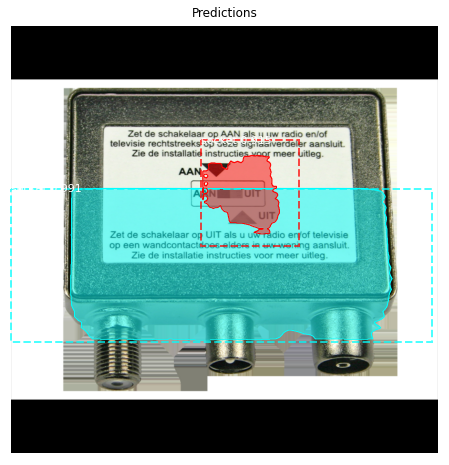

In [10]:
# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

## Predict random image (without the annotations)

In [11]:
from matplotlib.patches import Rectangle

def draw_image_with_boxes(filename, boxes_list):
     data = plt.imread(filename)
     plt.imshow(data)
     ax = plt.gca()
     for box in boxes_list:
          y1, x1, y2, x2 = box
          width, height = x2 - x1, y2 - y1
          rect = Rectangle((x1, y1), width, height, fill=False, color='red', lw=5)
          ax.add_patch(rect)
     plt.show()

In [12]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

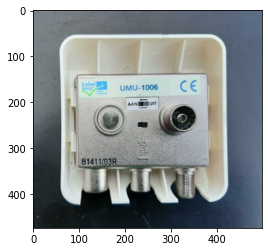

In [13]:
img_path = '/Users/wolfsinem/maskrcnn/dataset/SPLITTER-UMU-1006.jpeg'
img = load_img(img_path)
plt.imshow(img)

img = img_to_array(img)


In [14]:
results = model.detect([img], verbose=0)

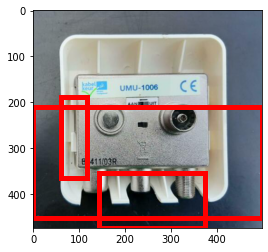

In [15]:
draw_image_with_boxes(img_path, results[0]['rois'])


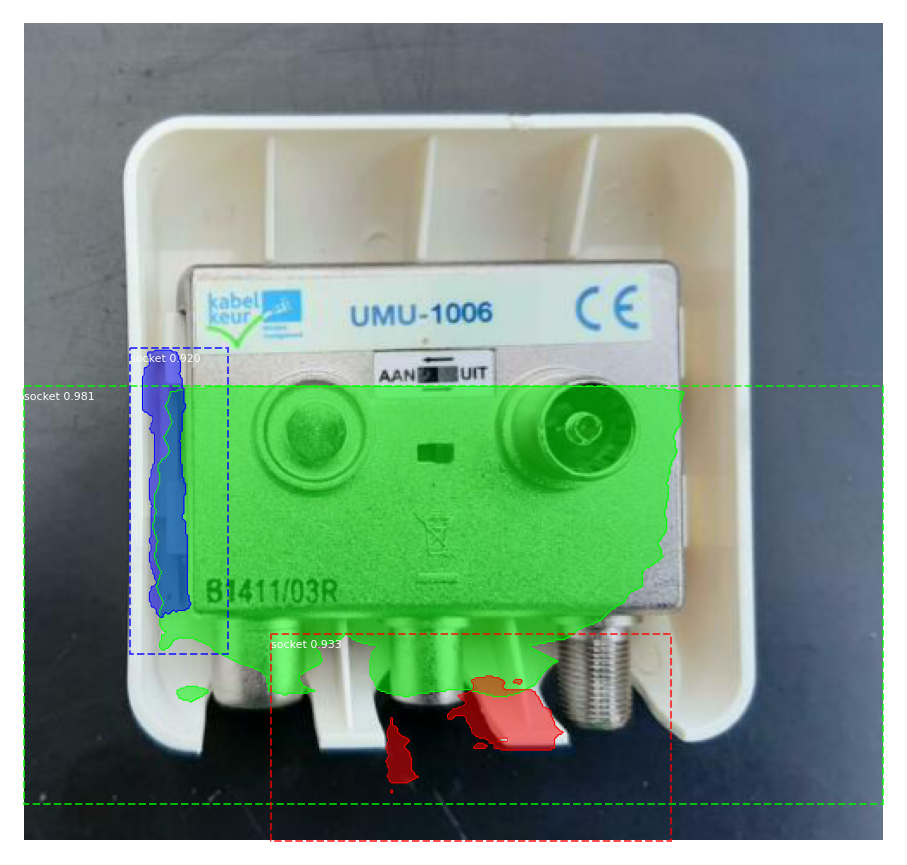

In [23]:
from mrcnn.visualize import display_instances
r = results[0]
display_instances(img, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])